<a href="https://colab.research.google.com/github/mlukan/GDA3B2021/blob/main/NN/Translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Introduction
In this exercise you will build three (optionally four) different networks to experiment with one of the applications of recurrent neural networks called Machine Translation. The preprocessing pipeline that prepares the input data for feeding into the neural network models is provided to you. Therefore, in this excercise you focus on building and experimenting with different network architectures. 

Optional: To learn more about recurrent neural networks (such as RNN, GRU, and LSTM) their architectures, the differences between them and their applications you can watch this free tutorial: [Sequences and Recurrent networks Tutorial](https://www.youtube.com/watch?v=87kLfzmYBy8&ab_channel=DeepMind)

In [1]:
# You may want to upgrade the tensorflow package to the latest verion (currently version 2.3) if you have the proper infrastructure
# !pip install --upgrade tensorflow
import tensorflow
tensorflow.__version__


'2.3.0'

### Setup


In [2]:
# To get access to a GPU instance you can use the `change runtime type` and set the option to `GPU` from the `Runtime` tab  in the notebook
# Checking the GPU availability for the notebook
import tensorflow
tensorflow.test.gpu_device_name()

''

In [3]:
# import collection
import io
import pandas as pd
import numpy as np
from typing import List 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional
from tensorflow.keras.layers import Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy

### Loading and Preprocessing the Data

#### Reading CSV data files as a list of strings, where each string represents a single line from the text


In [4]:
import csv
from io import TextIOWrapper, BytesIO

from zipfile import ZipFile
import requests

In [5]:
path="https://github.com/mlukan/GDA3B2021/raw/main/files/"
r = requests.get(path+'small-vocab-en.csv.zip')
    
with ZipFile(io.BytesIO(r.content))  as zf:
    with zf.open('small_vocab_en.csv', 'r') as infile:
            reader = csv.reader(TextIOWrapper(infile, 'utf-8'), delimiter='\n' )
            english_text = [item for sublist in reader for item in sublist]
            print(f"English text samples: {english_text[0:2]}")


English text samples: ['new jersey is sometimes quiet during autumn , and it is snowy in april .', 'the united states is usually chilly during july , and it is usually freezing in november .']


In [6]:
path="https://github.com/mlukan/GDA3B2021/raw/main/files/"
r = requests.get(path+'small-vocab-fr.csv.zip')
with ZipFile(io.BytesIO(r.content)) as zf:
    with zf.open('small_vocab_fr.csv', 'r') as infile:
        reader = csv.reader(TextIOWrapper(infile, 'utf-8'), delimiter='\n' )
        french_text = [item for sublist in reader for item in sublist]
        print(f"French translation text samples: {french_text[0:2]}")


French translation text samples: ["new jersey est parfois calme pendant l' automne , et il est neigeux en avril .", 'les états-unis est généralement froid en juillet , et il gèle habituellement en novembre .']


In [7]:
# TODO: Data exploration -> calculate and print some statistics on data
print(len(english_text),len(french_text))
eng_wordlist= ' '.join(english_text).split(' ')
fr_wordlist = ' '.join(french_text).split(' ')
print(len(''.join(english_text)),len(''.join(french_text)))


137860 137860
8947407 9709204


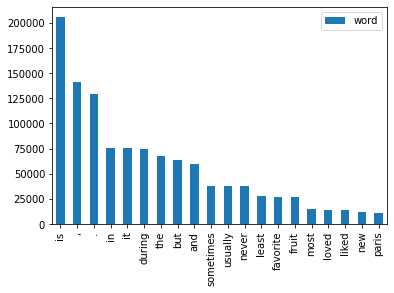

In [8]:
# Create a dictionary with words as keys and zero values from a set of all the words in the english text
eng_dict={k:0 for k in set(eng_wordlist)}
# Fill the english wordcount dictionary 
for w in eng_wordlist:
    eng_dict[w]+=1
# Create a dataframe, sort by count and plot a frequency histogram of the 20 most frequent words
eng_df=pd.DataFrame.from_dict(eng_dict, orient='index',columns=['word'])
eng_df.sort_values(by='word',ascending=False).iloc[:20,].plot.bar();


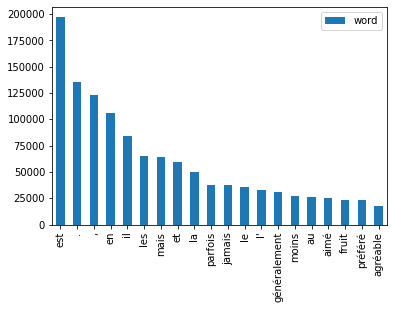

In [9]:
fr_dict = {k:0 for k in set(fr_wordlist)}
for w in fr_wordlist:
    fr_dict[w]+=1
fr_df=pd.DataFrame.from_dict(fr_dict, orient='index',columns=['word'])
fr_df.sort_values(by='word',ascending=False).iloc[:20,].plot.bar();


#### Tokenizing the data

Since the input data to neural networks needs to be in numerical format, we first turn each sentence into a sequence of word ids using `Tokenizer` function from Keras. Word ids are numerical presentations for words. 

In [10]:
def tokenize(x: List[str]):
  """Tokenizes sentences into word ids.
    Tokenize x
    :param x: List of sentences/strings to be tokenized
    :return: Tuple of (tokenized x data, tokenizer used to tokenize x)

  """
  tokenizer=Tokenizer()
  tokenizer.fit_on_texts(x)
  t=tokenizer.texts_to_sequences(x)
  return t, tokenizer

# Tokenize Example output
text_sentences = [
    'The quick brown fox jumps over the lazy dog .',
    'By Jove , my quick study of lexicography won a prize .',
    'This is a short sentence .']
text_tokenized, text_tokenizer = tokenize(text_sentences)
print(text_tokenizer.word_index)
for sample_i, (sent, token_sent) in enumerate(zip(text_sentences, text_tokenized)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(sent))
    print('  Output: {}'.format(token_sent)) 

{'the': 1, 'quick': 2, 'a': 3, 'brown': 4, 'fox': 5, 'jumps': 6, 'over': 7, 'lazy': 8, 'dog': 9, 'by': 10, 'jove': 11, 'my': 12, 'study': 13, 'of': 14, 'lexicography': 15, 'won': 16, 'prize': 17, 'this': 18, 'is': 19, 'short': 20, 'sentence': 21}
Sequence 1 in x
  Input:  The quick brown fox jumps over the lazy dog .
  Output: [1, 2, 4, 5, 6, 7, 1, 8, 9]
Sequence 2 in x
  Input:  By Jove , my quick study of lexicography won a prize .
  Output: [10, 11, 12, 2, 13, 14, 15, 16, 3, 17]
Sequence 3 in x
  Input:  This is a short sentence .
  Output: [18, 19, 3, 20, 21]


#### Padding Sequences

To be able to batch the sequences of word ids together, all sequences need to be of the same length. Therefore, as a second preprocessing step we make sure that all the English sentences have the same length as their respective French translations using `pad_sequence` function form Keras.

In [11]:
def pad(x, length=None):
    """
    Pad x
    :param x: List of sequences.
    :param length: Length to pad the sequence to.  If None, use length of longest sequence in x.
    :return: Padded numpy array of sequences
    """
    padding=pad_sequences(x,padding='post',maxlen=length)
    return padding

# Pad Tokenized output
test_pad = pad(text_tokenized)
for sample_i, (token_sent, pad_sent) in enumerate(zip(text_tokenized, test_pad)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(np.array(token_sent)))
    print('  Output: {}'.format(pad_sent))

Sequence 1 in x
  Input:  [1 2 4 5 6 7 1 8 9]
  Output: [1 2 4 5 6 7 1 8 9 0]
Sequence 2 in x
  Input:  [10 11 12  2 13 14 15 16  3 17]
  Output: [10 11 12  2 13 14 15 16  3 17]
Sequence 3 in x
  Input:  [18 19  3 20 21]
  Output: [18 19  3 20 21  0  0  0  0  0]


#### Preprocessing Pipeline

As mentioned in the introduction section in this excercise your focus is on building different recurrent neural network architectures. Threfore, in the following cell we provide you with a preprocessing pipeline. You can apply this function to the input data to prepare the data for using in neural networks.

In [12]:
def preprocess(x, y):
    """
     Preprocess input (x) and target (y)
    :param x: Feature List of sentences
    :param y: Label List of sentences
    :return: Tuple of (Preprocessed x, Preprocessed y, x tokenizer, y tokenizer)
    """
    preprocess_x, x_tk = tokenize(x)
    preprocess_y, y_tk = tokenize(y)

    preprocess_x = pad(preprocess_x)
    preprocess_y = pad(preprocess_y)

    # Keras's sparse_categorical_crossentropy function requires the labels to be in 3 dimensions
    preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)

    return preprocess_x, preprocess_y, x_tk, y_tk

preproc_english_sentences, preproc_french_sentences, english_tokenizer, french_tokenizer =\
    preprocess(english_text, french_text)
    
max_english_sequence_length = preproc_english_sentences.shape[1]
max_french_sequence_length = preproc_french_sentences.shape[1]
english_vocab_size = len(english_tokenizer.word_index)
french_vocab_size = len(french_tokenizer.word_index)

print('Preprocessed Data Info')
print("Max English sentence length:", max_english_sequence_length)
print("Max French sentence length:", max_french_sequence_length)
print("English vocabulary size:", english_vocab_size)
print("French vocabulary size:", french_vocab_size)

Preprocessed Data Info
Max English sentence length: 15
Max French sentence length: 21
English vocabulary size: 199
French vocabulary size: 344


In [13]:
preproc_english_sentences.shape
preproc_french_sentences.shape

(137860, 21, 1)

### Models

In this section we ask you to build and train Three (optionally four) different neural networks and use them to predict the French Translation of the English sentences.

Make use of the `logits_to_text()` function to transform the logits from output of your networks to a French translation. This helps you to better understand the output of the neural network.

In [14]:
def logits_to_text(logits, tokenizer):
    """
    Turn logits from a neural network into text using the tokenizer
    :param logits: Logits from a neural network
    :param tokenizer: Keras Tokenizer fit on the labels
    :return: String that represents the text of the logits
    """
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

print('`logits_to_text` function loaded.')

`logits_to_text` function loaded.


#### Model 1: Implement a simple RNN network and train the network. 


In [15]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential





In [25]:
preproc_english_sentences=preproc_english_sentences.reshape(preproc_english_sentences.shape[0],preproc_english_sentences.shape[1],1)
preproc_english_sentences.shape
preproc_french_sentences=preproc_french_sentences.reshape(preproc_french_sentences.shape[0],preproc_french_sentences.shape[1],1)
preproc_english_sentences.shape


(137860, 15, 1)

In [30]:
tmp_x=pad(preproc_english_sentences,max_french_sequence_length)
tmp_x = tmp_x.reshape((-1),preproc_french_sentences.shape[-2],1)

In [31]:
tmp_x.shape

(137860, 21, 1)

In [35]:
# Model 1: simple RNN model
def rnn_model(input_shape, output_sequence_length, english_vocab_size,french_vocab_size): #, english_vocab_size, french_vocab_size):
    """
    Build and train a basic RNN on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    # TODO: Build the layers and compile the model. (Hint: Use a GRU network followed by a TimeDistributed dense layer from tensorflow.keras.layers module)
    '''    
    from tensorflow.keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional
    from tensorflow.keras.layers import Embedding
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.losses import sparse_categorical_crossentropy
    '''
    model = Sequential()
    model.add(Input(shape=input_shape[1:]))
    model.add(GRU(english_vocab_size,return_sequences=True))
    model.add(TimeDistributed(Dense(french_vocab_size)))
    

    model.summary()
        # What is the input shape of your model? Which activation function do you choose for the dense layer?   
    return model

        # Hyperparameters
    
    # TODO: Build the layers
 
    # Compile model
 

model = rnn_model(tmp_x.shape,max_french_sequence_length,english_vocab_size+1,french_vocab_size+1) 
# TODO: Preprocess and reshape the input to work with a basic RNN. (Hint: Use preproc_english_sentences, preproc_french_sentences and reshape function from keras)
learning_rate = 0.003

model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
hist=model.fit(tmp_x,preproc_french_sentences)
# TODO: Train the network you built in rnn_model. What size do you choose for the epochs, batch_size and validation_split?

# TODO: Print prediction(s) for one or more of the English sentences. Hint: Make use of the `logits_to_text` function for transforming output logits to text. 

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_11 (GRU)                 (None, 21, 100)           30900     
_________________________________________________________________
time_distributed_6 (TimeDist (None, 21, 21)            2121      
Total params: 33,021
Trainable params: 33,021
Non-trainable params: 0
_________________________________________________________________


InvalidArgumentError:  Received a label value of 260 which is outside the valid range of [0, 21).  Label values: 4 32 31 1 12 63 37 11 46 6 3 95 2 49 0 0 0 0 0 0 0 260 122 40 109 10 23 156 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 90 1 40 16 10 23 14 5 10 38 1 20 23 14 0 0 0 0 0 0 7 33 1 8 66 2 51 6 3 1 8 67 2 47 0 0 0 0 0 0 0 11 30 1 8 60 2 49 5 3 1 58 2 53 0 0 0 0 0 0 0 0 62 1 12 18 2 41 6 3 1 9 59 2 44 0 0 0 0 0 0 0 0 4 32 31 1 9 22 102 2 41 6 3 1 9 18 2 51 0 0 0 0 0 36 1 9 26 63 2 51 5 3 1 19 2 48 0 0 0 0 0 0 0 0 7 87 1 20 16 17 13 5 10 85 1 64 13 140 0 0 0 0 0 0 0 11 30 1 12 59 2 51 6 3 1 9 18 26 11 24 0 0 0 0 0 0 1 3 223 2 62 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 94 4 28 4 73 6 28 76 0 0 0 0 0 0 0 0 0 0 0 0 27 1 234 2 30 2 41 142 0 0 0 0 0 0 0 0 0 0 0 0 0 10 82 1 39 13 14 108 96 5 7 83 1 61 13 14 0 0 0 0 0 0 84 1 64 16 10 23 119 5 7 89 1 39 23 14 0 0 0 0 0 0 0 4 32 31 1 19 2 43 5 3 1 8 92 2 48 0 0 0 0 0 0 0 106 128 91 28 76 4 71 6 4 72 0 0 0 0 0 0 0 0 0 0 0 4 32 31 1 8 137 2 54 5 3 1 69 21 2 43 0 0 0 0 0 0 7 33 1 12 66 2 54 5 3 1 21 26 11 24 0 0 0 0 0 0 0 36 1 9 19 2 49 6 3 1 69 21 2 43 0 0 0 0 0 0 0 0 7 89 1 20 16 17 5 10 82 1 40 93 0 0 0 0 0 0 0 0 0 29 1 8 57 37 11 44 5 3 1 12 67 2 51 0 0 0 0 0 0 0 106 128 91 4 28 4 75 6 4 70 0 0 0 0 0 0 0 0 0 0 0 7 33 1 104 37 11 46 6 3 1 9 60 2 41 0 0 0 0 0 0 0 62 1 12 66 15 25 22 45 5 3 1 8 57 2 52 0 0 0 0 0 0 27 100 4 72 4 73 6 4 75 0 0 0 0 0 0 0 0 0 0 0 0 10 38 1 20 13 14 108 96 5 84 1 64 13 14 0 0 0 0 0 0 0 231 106 46 26 29 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 99 124 4 74 4 77 6 4 70 0 0 0 0 0 0 0 0 0 0 0 0 62 1 18 26 98 6 3 1 9 68 2 46 0 0 0 0 0 0 0 0 0 3 100 4 75 4 73 6 4 72 0 0 0 0 0 0 0 0 0 0 0 0 62 1 9 26 63 2 43 5 3 1 8 92 2 46 0 0 0 0 0 0 0
	 [[node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits (defined at <ipython-input-35-fde6edaa5a46>:42) ]] [Op:__inference_train_function_27600]

Function call stack:
train_function


#### Model 2: Implement an RNN model using word embeddings

Embeddings are better representation of words. An embedding is a vector representation of a word in n-dimensional space, where n represents the size of the embedding vector.


In [ ]:
# Model 2: Embedding
def embed_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a RNN model using word embedding on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    # TODO: Build the layers and compile the model. (Hint: Similar to the first model use a GRU network followed by a TimeDistributed dense layer from tensorflow.keras.layers module. 
    # And this time make use of Embedding as well!)
    # What is the input shape of your model? Which activation function do you choose for the dense layer?

    return model

# TODO: Preprocess and reshape the input to work with a basic RNN. (Hint: Use preproc_english_sentences, preproc_french_sentences and reshape function from keras)

# TODO: Train the network you built in rnn_model. What size do you choose for the epochs, batch_size and validation_split?

# TODO: Print prediction(s) for one or more of the English sentences. Hint: Make use of the `logits_to_text` function for transforming output logits to text. 
# (Hint: If you predict on the same sentence you can compare the result of different model on that specific sentence with each other.)


#### Model 3: Implement a Bidirectional RNN network.

One of the restrictions of RNN networks is that they only see the data from past. However, Bidirectional RNNs can see the data in both directions past and future. Make use of Bidirectionality and experiment if this feature enhances your network's performance or not.

In [ ]:
# Model 3: Bidirectional RNNs
def bd_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a bidirectional RNN model on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    # TODO:  Build the layers and compile the model. (Hint: Similar to the first model use a GRU network followed by a TimeDistributed dense layer from tensorflow.keras.layers module. 
    # Don't forget to make your network bidirectional!)

    return model


# TODO: Print prediction(s) for one or more of the English sentences. Hint: Make use of the `logits_to_text` function for transforming output logits to text.
# (Hint: If you predict on the same sentence you can compare the result of different model on that specific sentence with each other.)


#### Model 4: Implement an Encoder-Decoder model (Optional)

In [ ]:

def encdec_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train an encoder-decoder model on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    # OPTIONAL: Implement

    return model


# OPTIONAL: Train and Print prediction(s)


#### Finally, you can use all the models you built in this exercise to create a model that incorporates embedding and bidirectionality into one model. (Optional)

In [ ]:

def model_final(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a model that incorporates embedding, encoder-decoder, and bidirectional RNN on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    # TODO: Implement

    return model
# OPTIONAL: Train and Print prediction(s)

### Final Notes and TODOs




*   In this exercise we focus on  learning different recurrent network architectures for machine translation, However we don't evaluate the models on a separate test set. To follow best machine learning practices, you can make use of the `sklearn.model_selecttion.train_test_split()` function to create separate training and test datasets. You can then retrain each of the models on the training set and evaluate the prediction accuracy using the hold out set. Observe how the best model performance might change.
* If you don't have any idea about French (like me :D) you can use a translater like [google translat](https://translate.google.com/) to compare the prediction(s) from your models with the respective original English sentence(s).
*   TODO: Finally, you can also try to train and predict your models on other language pairs. As a convenient example, you can use your models to translate from French to English since you already have the data available.



